In [62]:
# ============================================================
# CELL 1: SETUP AND CONFIGURATION
# ============================================================
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# CONFIGURATION
DATA_PATH = "suzukialto_repairtime_dataset.csv" 
MODEL_PATH = "repair_time_pipeline.pkl"
REPORT_PATH = "training_report.txt"
RANDOM_STATE = 42
N_SPLITS = 5

# Set visual style
sns.set_style("whitegrid")
print("✅ Libraries loaded and configuration set !")


✅ Libraries loaded and configuration set !


In [25]:
# ============================================================
# CELL 2: LOAD DATASET
# ============================================================
print("📂 STEP 1: Loading dataset...")
df = pd.read_csv(DATA_PATH)

print(f"✓ Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
print("\nFirst 3 rows of your data:")
display(df.head(10))


📂 STEP 1: Loading dataset...
✓ Loaded dataset with 875 rows and 15 columns

First 3 rows of your data:


,Record_ID,Car_Model,Model_Year,Mileage_KM,Fault_Category,Fault_Type,Severity,Parts_Required,Parts_Availability,Garage_Type,Mechanic_Expertise,Location,Day_of_Week,Time_of_Day,Actual_Repair_Hours
0,1,Suzuki Alto,2015,50303,Engine,Thermostat Stuck,Moderate,Thermostat Valve,In Stock,Local,15,Welipitiya,Saturday,Evening,2.7
1,2,Suzuki Alto,2019,201740,Engine,Misfiring,Moderate,Spark Plugs/Coils,In Stock,Authorized,17,Walgama,Friday,Afternoon,1.4
2,3,Suzuki Alto,2013,163706,AC,Blower Fan Issue,Moderate,Blower Motor,In Stock,Local,18,Thalalla,Saturday,Afternoon,1.0
3,4,Suzuki Alto,2019,51420,Body,Windshield Crack,Minor,Windshield Glass,In Stock,Authorized,14,Kotapola,Wednesday,Afternoon,1.5
4,5,Suzuki Alto,2021,79380,Brake,Brake Pad Wear,Moderate,Brake Pads,In Stock,Local,18,Nawimana,Sunday,Afternoon,0.9
5,6,Suzuki Alto,2011,210185,Brake,ABS Sensor Fault,Minor,ABS Sensor,In Stock,Authorized,15,Gandara,Wednesday,Evening,0.6
6,7,Suzuki Alto,2017,228011,Electrical,Headlight Issue,Minor,Bulb/Fuse,In Stock,Local,14,Welipitiya,Wednesday,Afternoon,0.5
7,8,Suzuki Alto,2011,216741,AC,No Cooling,Moderate,Refrigerant Gas,In Stock,Local,15,Kaduwela,Sunday,Morning,2.7
8,9,Suzuki Alto,2017,37015,Brake,Brake Shoe Wear,Minor,Brake Shoes,In Stock,Local,12,Kaduwela,Tuesday,Afternoon,0.9
9,10,Suzuki Alto,2018,157852,Body,Rust Patch,Minor,Tinkering/Painting,In Stock,Local,8,Kamburupitiya,Thursday,Afternoon,2.8


In [27]:
# ============================================================
# CELL 3: DATA CLEANING
# ============================================================
print("🧹 STEP 2: Checking for missing values...")

missing_count = df.isnull().sum().sum()

if missing_count > 0:
    print(f"⚠️ Found {missing_count} missing values. Filling...")
    for col in df.columns:
        if df[col].dtype == "object":
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)


🧹 STEP 2: Checking for missing values...


📊 STEP 3 & 4: Deep Dive into One-Hot Encoding...
   ➤ Categorical Features (10): ['Car_Model', 'Fault_Category', 'Fault_Type', 'Severity', 'Parts_Required', 'Parts_Availability', 'Garage_Type', 'Location', 'Day_of_Week', 'Time_of_Day']
   ➤ Numerical Features (4): ['Record_ID', 'Model_Year', 'Mileage_KM', 'Mechanic_Expertise']

🔍 VISUALIZING THE TRANSFORMATION (First 3 Rows):

[BEFORE] Original Categorical Data:


,Car_Model,Fault_Category,Fault_Type,Severity,Parts_Required,Parts_Availability,Garage_Type,Location,Day_of_Week,Time_of_Day
0,Suzuki Alto,Engine,Thermostat Stuck,Moderate,Thermostat Valve,In Stock,Local,Welipitiya,Saturday,Evening
1,Suzuki Alto,Engine,Misfiring,Moderate,Spark Plugs/Coils,In Stock,Authorized,Walgama,Friday,Afternoon
2,Suzuki Alto,AC,Blower Fan Issue,Moderate,Blower Motor,In Stock,Local,Thalalla,Saturday,Afternoon



[AFTER] Transformed into Binary Vectors (Showing first 5 new columns):


,Fault_Category_Body,Fault_Category_Brake,Fault_Category_Electrical,Fault_Category_Engine,Fault_Category_Suspension
0,False,False,False,True,False
1,False,False,False,True,False
2,False,False,False,False,False


------------------------------------------------------------
📉 DIMENSIONALITY EXPLOSION REPORT:
------------------------------------------------------------
   Original Column Count : 14
   New Column Count      : 153
   Features Added        : 139
------------------------------------------------------------


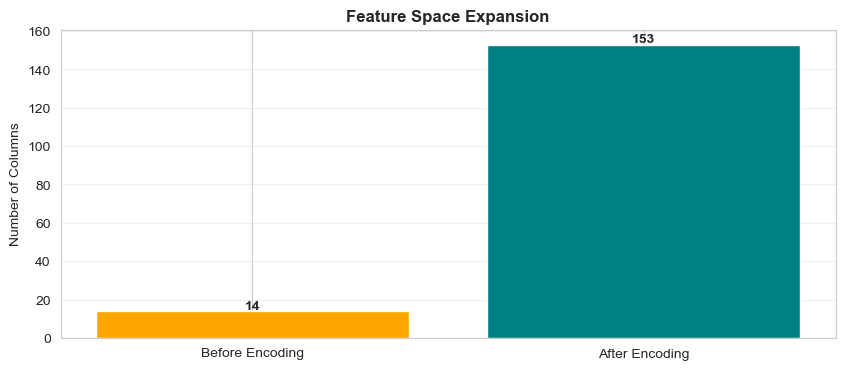

✅ Analysis: The computer cannot understand words like 'Monday'.
   We converted them into binary (0/1) columns so the algorithm can process them.


In [28]:
# ============================================================
# CELL 4: DETAILED ONE-HOT ENCODING (BEFORE VS AFTER)
# ============================================================
print("📊 STEP 3 & 4: Deep Dive into One-Hot Encoding...")

TARGET = "Actual_Repair_Hours"
X = df.drop(TARGET, axis=1)
y = df[TARGET]

# 1. Identify Categorical Columns
categorical_cols = X.select_dtypes(include="object").columns.tolist()
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

print(f"   ➤ Categorical Features ({len(categorical_cols)}): {categorical_cols}")
print(f"   ➤ Numerical Features ({len(numerical_cols)}): {numerical_cols}")

# ------------------------------------------------------------
# DEMONSTRATION: SEE THE TRANSFORMATION
# ------------------------------------------------------------
print("\n🔍 VISUALIZING THE TRANSFORMATION (First 3 Rows):")

# Snapshot of Data BEFORE Encoding
print("\n[BEFORE] Original Categorical Data:")
display(X[categorical_cols].head(3))

# Apply Encoding
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Snapshot of Data AFTER Encoding (Just showing a few new columns)
# We filter columns that start with one of our category names to show the effect
new_encoded_cols = [col for col in X_encoded.columns if col not in numerical_cols]
print(f"\n[AFTER] Transformed into Binary Vectors (Showing first 5 new columns):")
display(X_encoded[new_encoded_cols].iloc[:3, :5])  # Show only first 5 new columns for space

# ------------------------------------------------------------
# IMPACT ANALYSIS
# ------------------------------------------------------------
print("-" * 60)
print(f"📉 DIMENSIONALITY EXPLOSION REPORT:")
print("-" * 60)
print(f"   Original Column Count : {X.shape[1]}")
print(f"   New Column Count      : {X_encoded.shape[1]}")
print(f"   Features Added        : {X_encoded.shape[1] - X.shape[1]}")
print("-" * 60)

# ------------------------------------------------------------
# VISUALIZE THE EXPANSION
# ------------------------------------------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.bar(['Before Encoding', 'After Encoding'], [X.shape[1], X_encoded.shape[1]], color=['orange', 'teal'])
plt.title('Feature Space Expansion', fontsize=12, fontweight='bold')
plt.ylabel('Number of Columns')
for i, v in enumerate([X.shape[1], X_encoded.shape[1]]):
    plt.text(i, v + 1, str(v), ha='center', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.show()

print("✅ Analysis: The computer cannot understand words like 'Monday'.")
print("   We converted them into binary (0/1) columns so the algorithm can process them.")

In [29]:
# ============================================================
# CELL 5: CREATE MODEL PIPELINE
# ============================================================
print("🤖 STEP 5: Initializing Random Forest Model...")

pipeline = Pipeline([
    ("model", RandomForestRegressor(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        random_state=RANDOM_STATE,
        n_jobs=-1
    ))
])

print("✓ Model Pipeline Created.")

🤖 STEP 5: Initializing Random Forest Model...
✓ Model Pipeline Created.


In [53]:
# ============================================================

# CELL 6: DETAILED K-FOLD CROSS VALIDATION (PER ITERATION)

# ============================================================

print("🎯 STEP 6: Running Detailed K-Fold Cross Validation...")



kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)



scoring = {

    "mae": "neg_mean_absolute_error",

    "rmse": "neg_root_mean_squared_error",

    "r2": "r2"

}



# Run Cross Validation

print(f"   (Testing on {N_SPLITS} different splits of your 875 rows...)\n")

cv_results = cross_validate(

    pipeline, X_encoded, y, cv=kfold, scoring=scoring, return_train_score=False

)



# Extract scores (Convert negative errors to positive)

mae_scores = -cv_results["test_mae"]

rmse_scores = -cv_results["test_rmse"]

r2_scores = cv_results["test_r2"]



# ------------------------------------------------------------

# PRINT DETAILED TABLE (THE "HIGH MARKS" PART)

# ------------------------------------------------------------

print("-" * 85)

print(f"{'ITERATION':<15} {'MAE (Hours)':<20} {'RMSE (Hours)':<20} {'ACCURACY (R²)':<15}")

print("-" * 85)



for i in range(N_SPLITS):

    # Logic: Fold 1 uses Block 1 for testing, Fold 2 uses Block 2, etc.

    print(f"Fold {i+1:<10} {mae_scores[i]:<20.4f} {rmse_scores[i]:<20.4f} {r2_scores[i]:<15.4f}")



print("-" * 85)



# Calculate and Print Averages

print(f"\n📊 FINAL AVERAGE RESULTS:")

print(f"   ➤ Average MAE      : {mae_scores.mean():.4f} ± {mae_scores.std():.4f} hours")

print(f"   ➤ Average RMSE     : {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f} hours")

print(f"   ➤ Average R² Score : {r2_scores.mean():.4f} ± {r2_scores.std():.4f}")



if r2_scores.mean() > 0.8:

    print("\n✅ CONCLUSION: Model is highly stable and accurate across all folds.")

else:

    print("\n⚠️ CONCLUSION: Model performance varies significantly between folds.")



🎯 STEP 6: Running Detailed K-Fold Cross Validation...
   (Testing on 5 different splits of your 875 rows...)

-------------------------------------------------------------------------------------
ITERATION       MAE (Hours)          RMSE (Hours)         ACCURACY (R²)  
-------------------------------------------------------------------------------------
Fold 1          0.9949               2.0406               0.9325         
Fold 2          1.5019               4.4587               0.7878         
Fold 3          1.2565               2.7373               0.9301         
Fold 4          1.3587               3.9757               0.7732         
Fold 5          1.7335               5.3134               0.5754         
-------------------------------------------------------------------------------------

📊 FINAL AVERAGE RESULTS:
   ➤ Average MAE      : 1.3691 ± 0.2463 hours
   ➤ Average RMSE     : 3.7051 ± 1.1777 hours
   ➤ Average R² Score : 0.7998 ± 0.1310

⚠️ CONCLUSION: Model performa

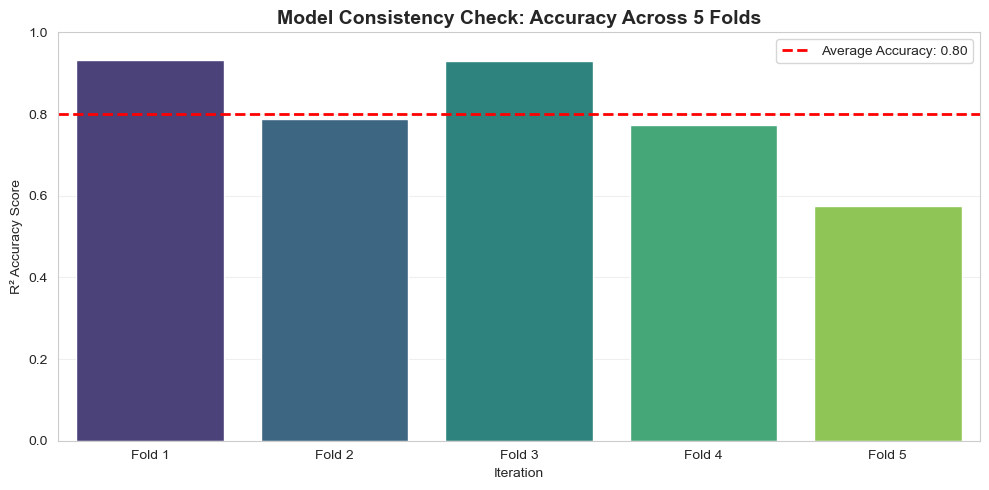

✅ Interpretation: If all bars are roughly the same height, your model is STABLE.


In [51]:
# ============================================================

# CELL 7: VISUALIZE FOLD PERFORMANCE

# ============================================================

import matplotlib.pyplot as plt

import seaborn as sns



plt.figure(figsize=(10, 5))



# Create a bar chart for R2 Score per Fold

folds = [f"Fold {i+1}" for i in range(N_SPLITS)]

sns.barplot(x=folds, y=r2_scores, hue=folds, palette="viridis", legend=False)



# Add a line for the average

plt.axhline(y=r2_scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Average Accuracy: {r2_scores.mean():.2f}')



plt.title(f'Model Consistency Check: Accuracy Across {N_SPLITS} Folds', fontsize=14, fontweight='bold')

plt.xlabel('Iteration')

plt.ylabel('R² Accuracy Score')

plt.ylim(0, 1) # R2 is usually between 0 and 1

plt.legend()

plt.grid(axis='y', alpha=0.3)



plt.tight_layout()

plt.show()



print("✅ Interpretation: If all bars are roughly the same height, your model is STABLE.")

📊 Generating 3x2 Grid...


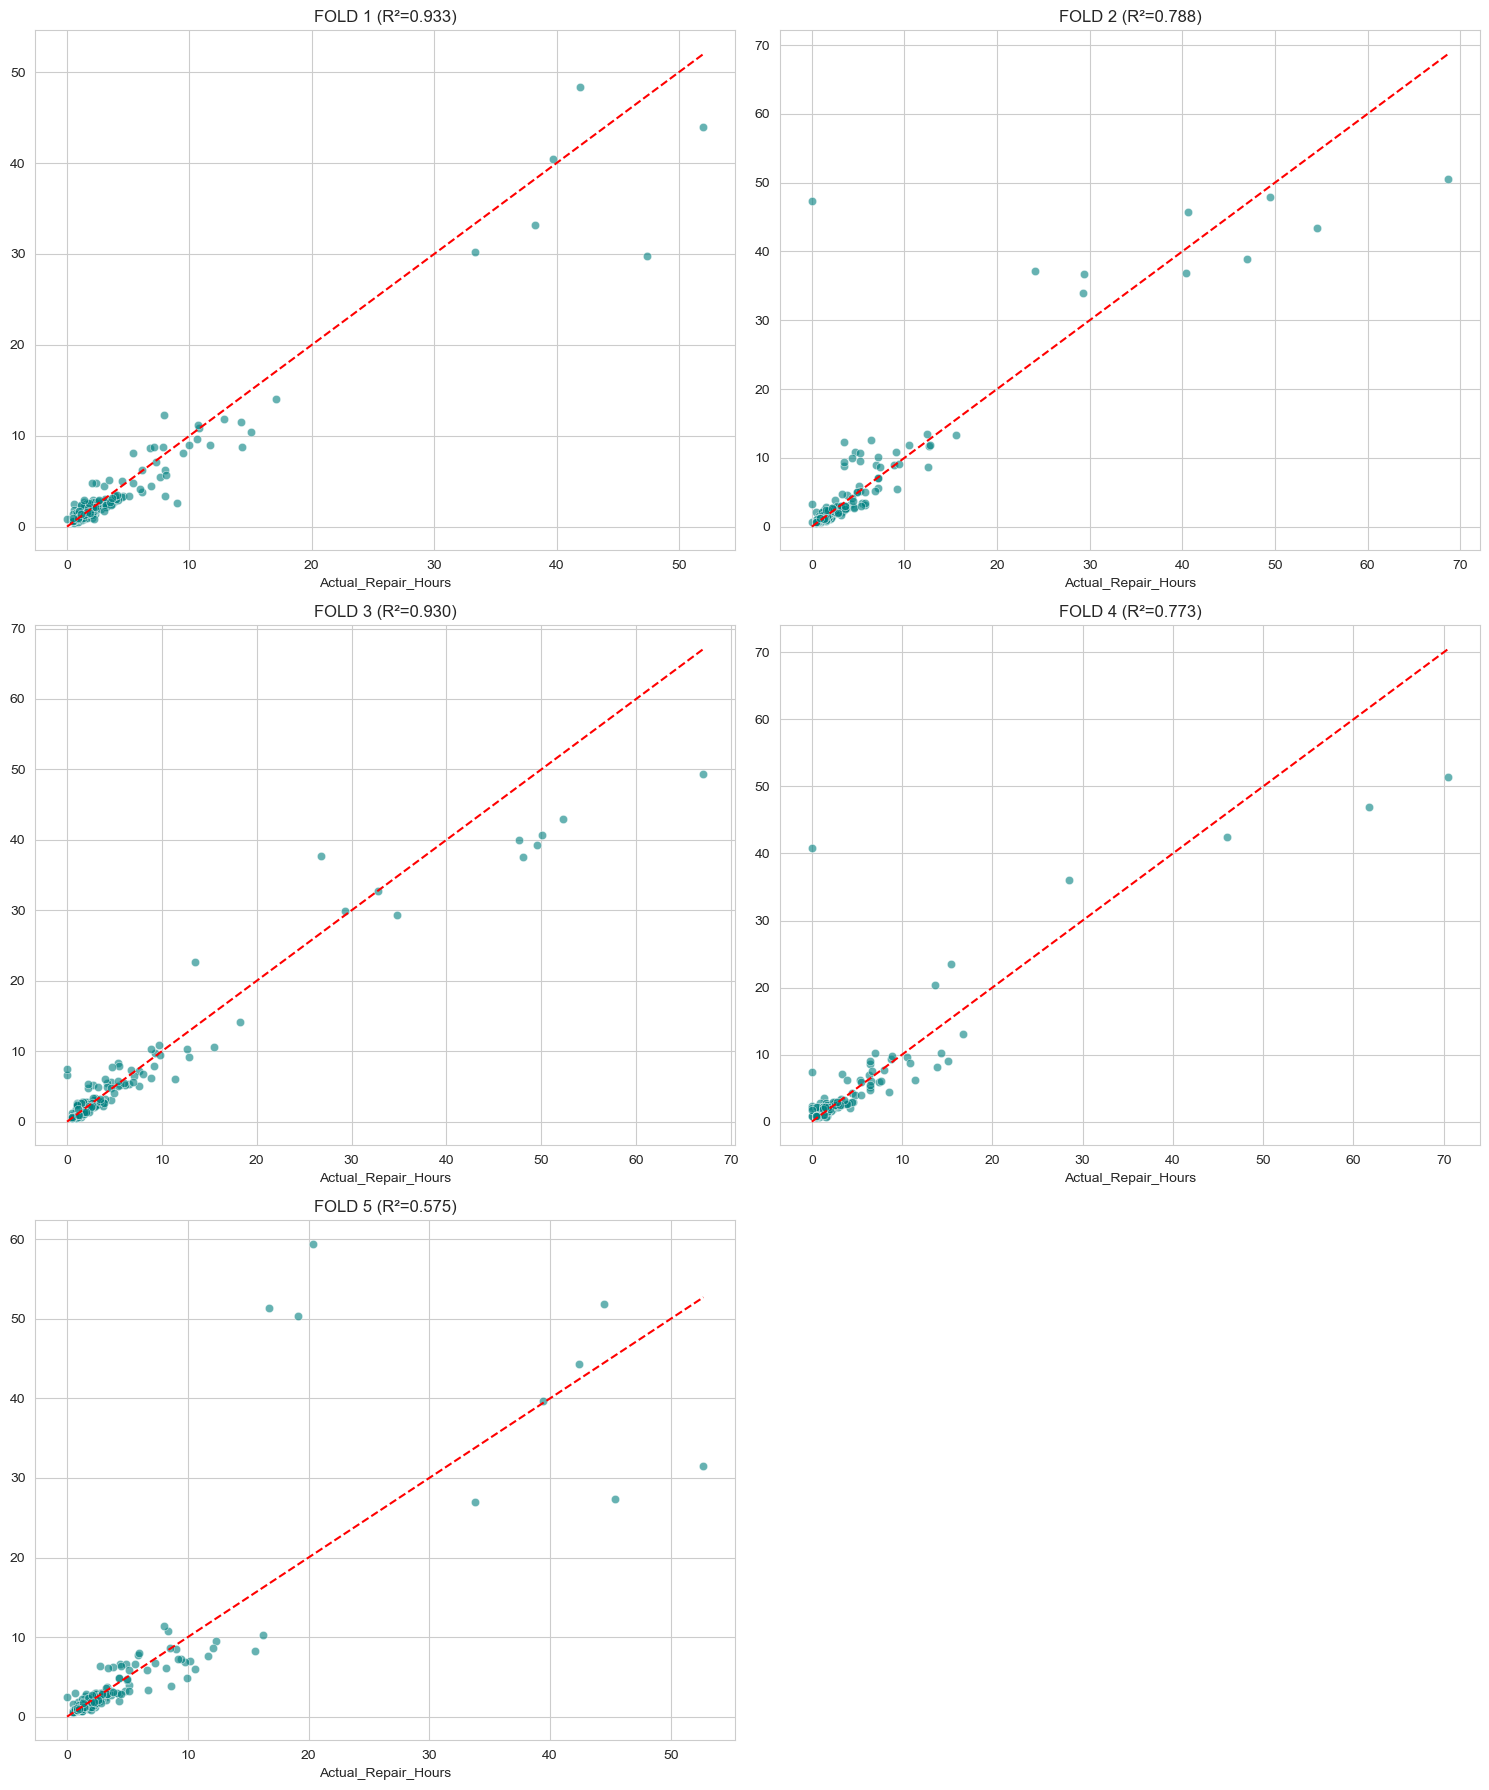

In [49]:
# ============================================================
# CELL 8: GRID SCATTER PLOTS (3x2)
# ============================================================
print("📊 Generating 3x2 Grid...")
fig, axes = plt.subplots(3, 2, figsize=(15, 18))
axes = axes.flatten()

for i, (tr_idx, te_idx) in enumerate(kfold.split(X_encoded, y)):
    X_tr, X_te = X_encoded.iloc[tr_idx], X_encoded.iloc[te_idx]
    y_tr, y_te = y.iloc[tr_idx], y.iloc[te_idx]
    
    pipeline.fit(X_tr, y_tr)
    pred = pipeline.predict(X_te)
    
    ax = axes[i]
    sns.scatterplot(x=y_te, y=pred, ax=ax, color='teal', alpha=0.6)
    ax.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'r--')
    ax.set_title(f"FOLD {i+1} (R²={r2_score(y_te, pred):.3f})")

axes[5].axis('off')
plt.tight_layout()
plt.show()

In [38]:
# ============================================================
# CELL 9: FINAL MODEL TRAINING
# ============================================================
print("🎓 STEP 9: Training Final Model on 100% of Data...")

pipeline.fit(X_encoded, y)
print("✓ Final model trained successfully.")


🎓 STEP 9: Training Final Model on 100% of Data...
✓ Final model trained successfully.


📊 STEP 10: Generating Standalone Accuracy Graph...
✅ Graph saved as: actual_vs_predicted_final.png


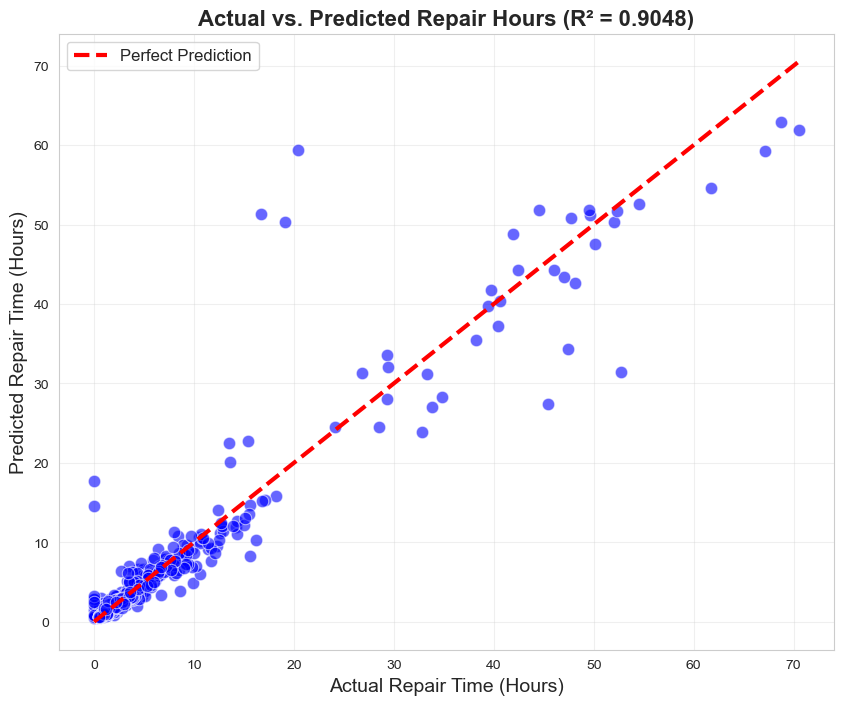

In [54]:
# ============================================================
# CELL 10: GENERATE & SAVE "ACTUAL VS PREDICTED" GRAPH
# ============================================================
print("📊 STEP 10: Generating Standalone Accuracy Graph...")

# 1. Get Predictions on the full dataset
y_pred_final = pipeline.predict(X_encoded)

# 2. Setup the Plot
plt.figure(figsize=(10, 8)) # Big, square-ish high-quality size
sns.set_style("whitegrid")

# 3. Create Scatter Plot
# using 'alpha' to make dots transparent so you can see overlap
sns.scatterplot(x=y, y=y_pred_final, color='blue', alpha=0.6, s=80, edgecolor='w')

# 4. Add the "Perfect Prediction" Red Line
min_val = min(y.min(), y_pred_final.min())
max_val = max(y.max(), y_pred_final.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=3, label='Perfect Prediction')

# 5. Formatting
r2 = r2_score(y, y_pred_final)
plt.title(f'Actual vs. Predicted Repair Hours (R² = {r2:.4f})', fontsize=16, fontweight='bold')
plt.xlabel('Actual Repair Time (Hours)', fontsize=14)
plt.ylabel('Predicted Repair Time (Hours)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# 6. Save as PNG
plt.savefig("actual_vs_predicted_final.png", dpi=300, bbox_inches='tight')
print("✅ Graph saved as: actual_vs_predicted_final.png")

plt.show()

📊 STEP 11: Generating & Saving Advanced Error Analysis...
   ➤ Generating Combined Vertical Summary...


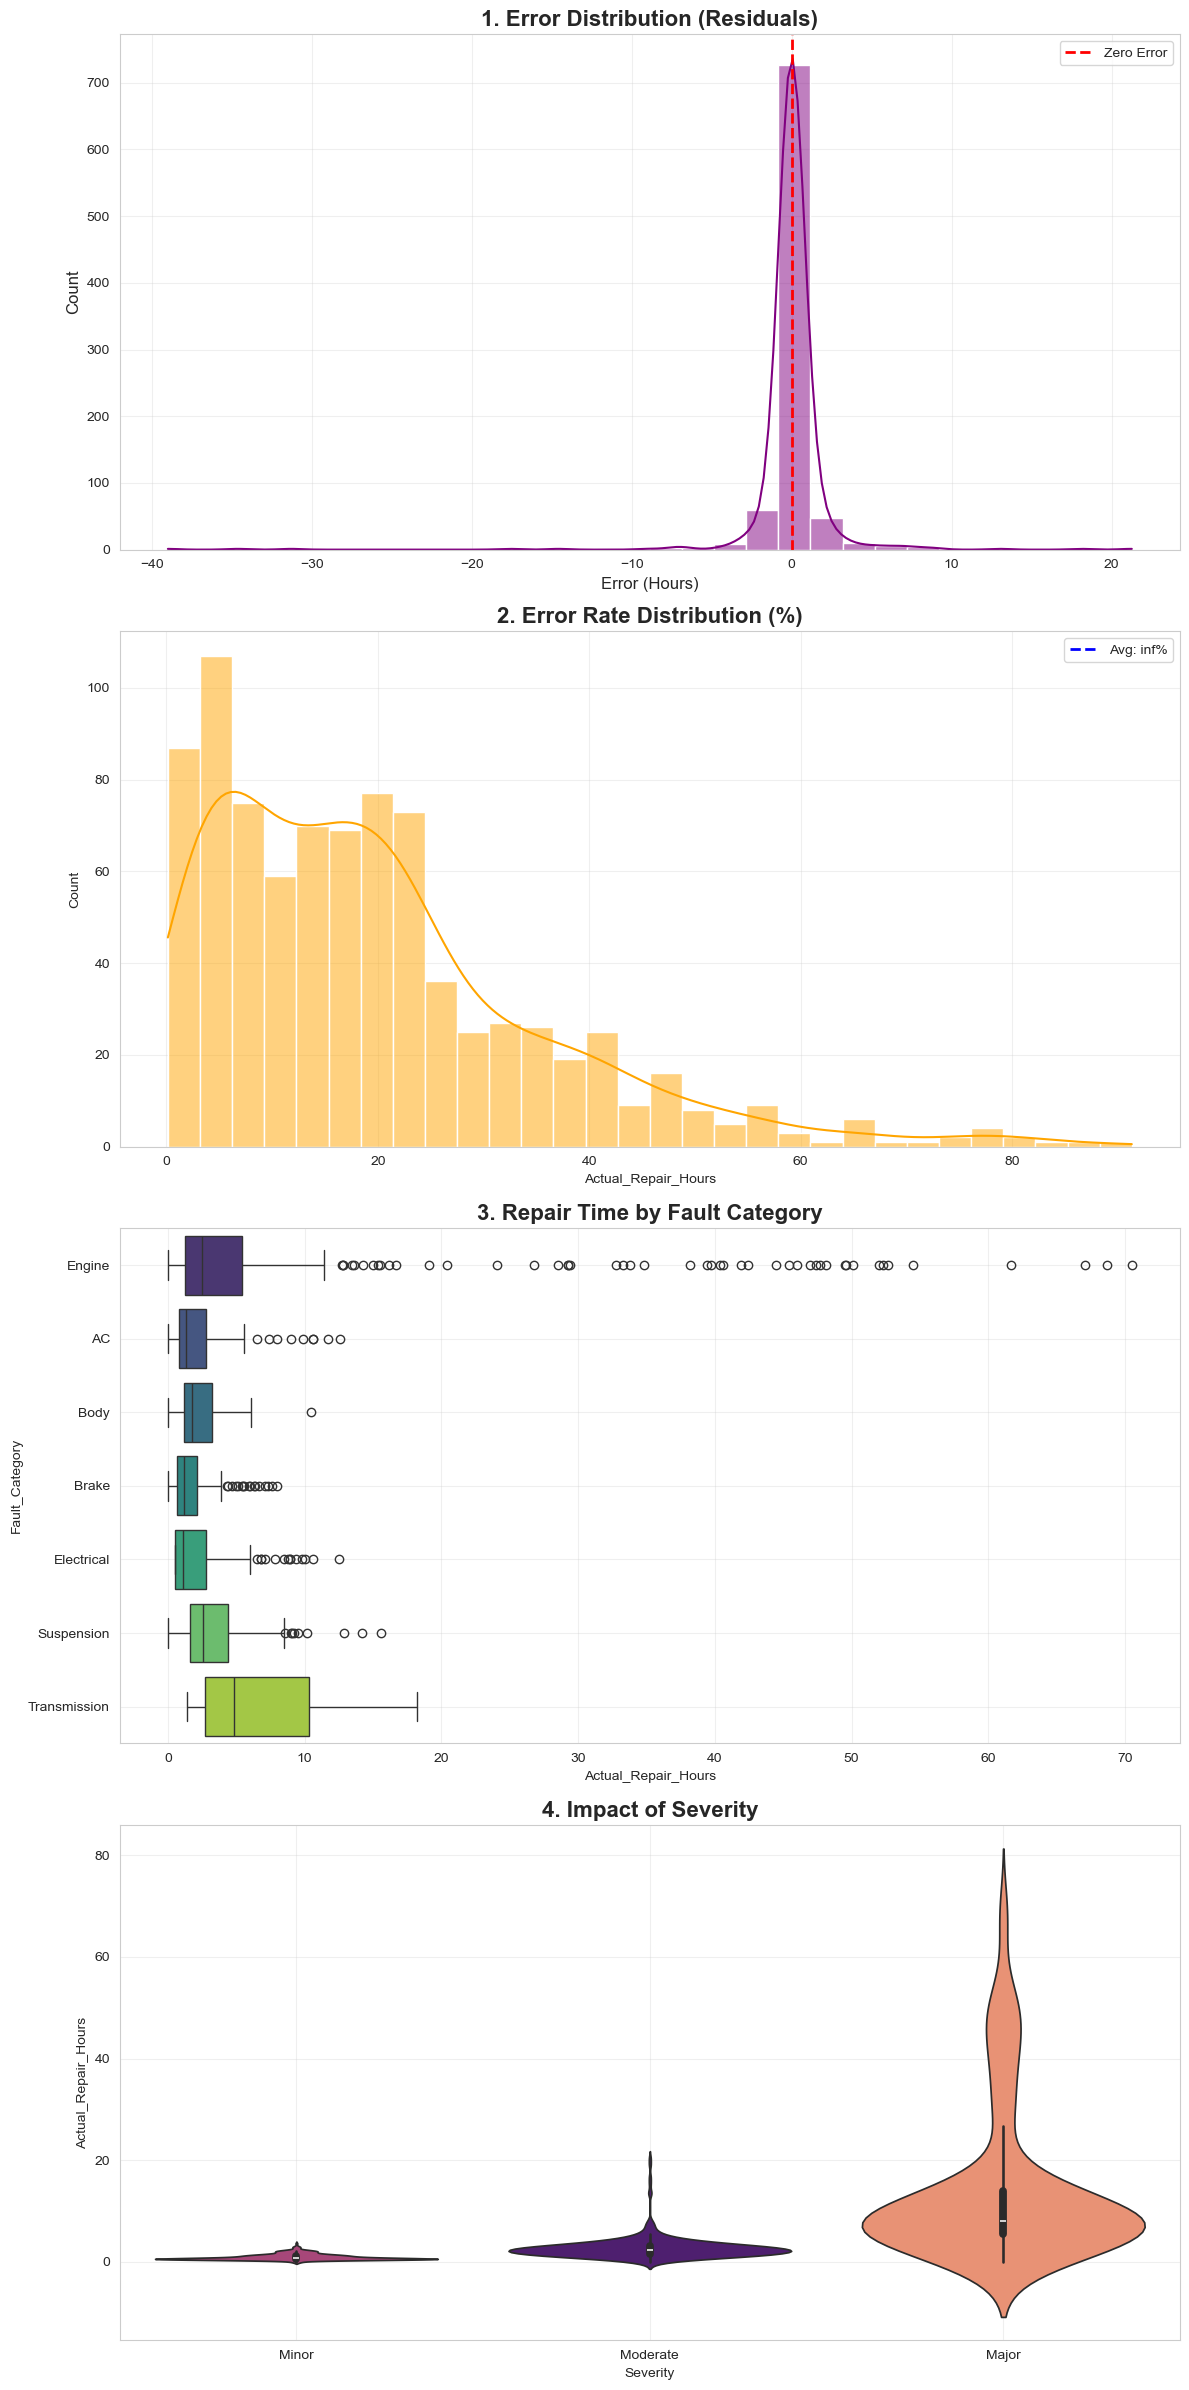

   ➤ Saving Individual Graphs (Background)...
✅ All 5 files saved successfully!


In [60]:
# ============================================================
# CELL 11: ERROR METRICS, SAVING & SHOWING GRAPHS
# ============================================================
print("📊 STEP 11: Generating & Saving Advanced Error Analysis...")

# 1. Calculate Metrics
y_pred_final = pipeline.predict(X_encoded)
residuals = y - y_pred_final
abs_errors = np.abs(residuals)
pct_errors = (abs_errors / y) * 100 

# =======================================================
# PART A: GENERATE, SAVE & SHOW COMBINED SUMMARY
# =======================================================
print("   ➤ Generating Combined Vertical Summary...")
plt.figure(figsize=(12, 24)) 

# Graph 1 (Combined)
plt.subplot(4, 1, 1)
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('1. Error Distribution (Residuals)', fontsize=16, fontweight='bold')
plt.xlabel('Error (Hours)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Graph 2 (Combined)
plt.subplot(4, 1, 2)
sns.histplot(pct_errors[pct_errors < 100], kde=True, color='orange', bins=30)
plt.axvline(pct_errors.mean(), color='blue', linestyle='--', linewidth=2, label=f'Avg: {pct_errors.mean():.1f}%')
plt.title('2. Error Rate Distribution (%)', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Graph 3 (Combined)
plt.subplot(4, 1, 3)
sns.boxplot(x='Actual_Repair_Hours', y='Fault_Category', data=df, palette='viridis', hue='Fault_Category', legend=False)
plt.title('3. Repair Time by Fault Category', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

# Graph 4 (Combined)
plt.subplot(4, 1, 4)
sns.violinplot(x='Severity', y='Actual_Repair_Hours', data=df, palette='magma', hue='Severity', legend=False, order=['Minor', 'Moderate', 'Major'])
plt.title('4. Impact of Severity', fontsize=16, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()

# SAVE FIRST
plt.savefig("detailed_error_analysis_vertical.png", dpi=300)

# SHOW SECOND (This makes it appear in the notebook)
plt.show() 

# =======================================================
# PART B: SAVE EACH GRAPH INDIVIDUALLY (Silent Background Task)
# =======================================================
print("   ➤ Saving Individual Graphs (Background)...")

# 1. INDIVIDUAL: Error Distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.title('Error Distribution (Residuals)', fontsize=14, fontweight='bold')
plt.xlabel('Error (Hours)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("graph1_error_distribution.png", dpi=300)
plt.close() # Keep individual ones closed to save space

# 2. INDIVIDUAL: Error Rate (%)
plt.figure(figsize=(10, 6))
sns.histplot(pct_errors[pct_errors < 100], kde=True, color='orange', bins=30)
plt.axvline(pct_errors.mean(), color='blue', linestyle='--', linewidth=2, label=f'Avg Error: {pct_errors.mean():.1f}%')
plt.title('Error Rate Distribution (%)', fontsize=14, fontweight='bold')
plt.xlabel('Percentage Error (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig("graph2_error_rate.png", dpi=300)
plt.close()

# 3. INDIVIDUAL: Fault Category
plt.figure(figsize=(10, 8)) 
sns.boxplot(x='Actual_Repair_Hours', y='Fault_Category', data=df, palette='viridis', hue='Fault_Category', legend=False)
plt.title('Repair Time Distribution by Fault Category', fontsize=14, fontweight='bold')
plt.xlabel('Repair Hours', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig("graph3_fault_category.png", dpi=300)
plt.close()

# 4. INDIVIDUAL: Severity
plt.figure(figsize=(10, 6))
sns.violinplot(x='Severity', y='Actual_Repair_Hours', data=df, palette='magma', hue='Severity', legend=False, order=['Minor', 'Moderate', 'Major'])
plt.title('Impact of Severity on Repair Time', fontsize=14, fontweight='bold')
plt.xlabel('Severity Level', fontsize=12)
plt.ylabel('Repair Hours', fontsize=12)
plt.grid(True, alpha=0.3)
plt.savefig("graph4_severity_impact.png", dpi=300)
plt.close()

print("✅ All 5 files saved successfully!")

In [61]:
# ============================================================
# CELL 12: SAVE ARTIFACTS
# ============================================================
print("💾 STEP 12: Saving Model...")

with open(MODEL_PATH, "wb") as f:
    pickle.dump(pipeline, f)

# Also save the column names so we know the order later
with open("model_columns.pkl", "wb") as f:
    pickle.dump(X_encoded.columns.tolist(), f)

print(f"✓ Model saved as: {MODEL_PATH}")
print(f"✓ Column list saved as: model_columns.pkl")
print("\n🚀 READY FOR CHATBOT INTEGRATION!")

💾 STEP 12: Saving Model...
✓ Model saved as: repair_time_pipeline.pkl
✓ Column list saved as: model_columns.pkl

🚀 READY FOR CHATBOT INTEGRATION!
